(2961, 2961)
Execution time: 1.6060097217559814
Space dimension: 60
H∞ norm: 0.8545689841971793


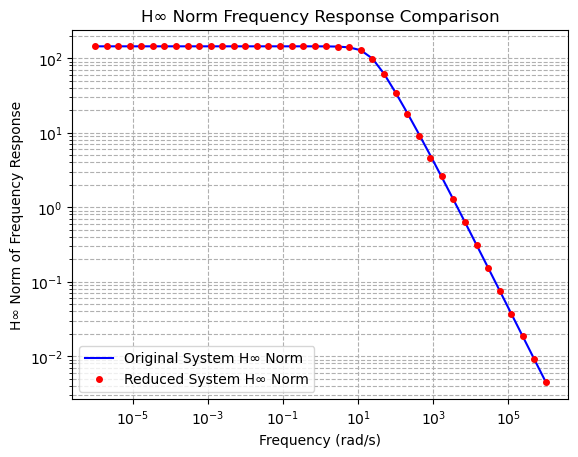

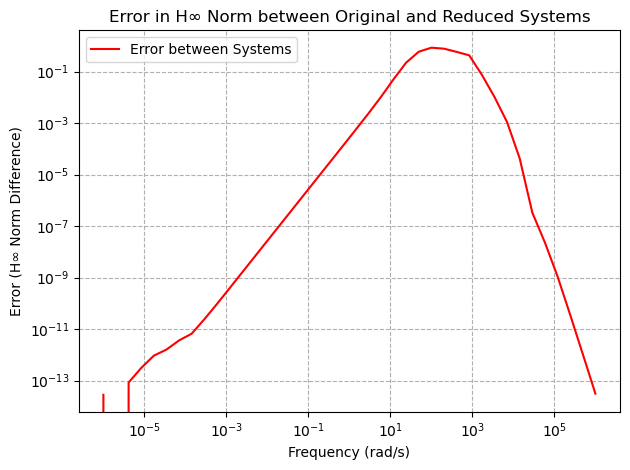

In [2]:
import time
import numpy as np
from scipy.linalg import lu_factor, lu_solve, qr
from scipy.signal import lti
from global_requirement import global_qr, diamond_product
from numerical_test1 import fdm_matrix1
from scipy.linalg import solve
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import mmread 
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds, LinearOperator, aslinearoperator
from scipy.sparse import eye, linalg as splinalg
import scipy.sparse as sps
from numerical_test1 import fdm_matrix1
from scipy.linalg import svdvals
from scipy.linalg import lu_factor, lu_solve, qr
from scipy.signal import lti
from build_matrix_A import build_matrix_A


def extended_global_arnoldi(A, V0, m):
    n, p = V0.shape
    V = np.zeros((n, 2*p*(m+1))) 
    H = np.zeros((2*(m+1), 2*m)) 
    T = np.zeros((2*(m+1), 2*m)) 
    lu, piv = lu_factor(A.toarray())
    A_1_V0 = lu_solve((lu, piv), V0)
    V0_new = np.hstack((V0, A_1_V0))  
    Q, R1 = global_qr(V0_new, p)
    V[:, :2*p] = Q
    w11 = np.linalg.norm(V0, 'fro')
    w12 = np.trace(V[:,:p].T @ A_1_V0)
    te = w12 * V[:,:p]
    U = A_1_V0 - w12 * V[:,:p]
    w22 = np.linalg.norm(U, 'fro')
    for j in range(m):
        Vj1 = V[:, 2*j*p:2*j*p + p]
        Vj2 = V[:, 2*j*p + p:2*(j+1)*p]
        AVj1 = A @  Vj1 
        A_invVj2 = lu_solve((lu, piv), Vj2)
        
        Wj = np.hstack((AVj1, A_invVj2))
       
        for i in range(j+1):
            H_ij = diamond_product(V[:, 2*i*p:2*(i+1)*p].T, Wj, p)
            H[2*i:2*i+2, 2*j:2*j+2] = H_ij
            Wj = Wj - V[:, 2*i*p:2*(i+1)*p] @ np.kron(H_ij,np.eye(p))
           
            
        Q, R1 = global_qr(Wj, p)
        V[:, 2*(j+1)*p:2*(j+2)*p] = Q
        H[2*(j+1):2*(j+1)+2, 2*j:2*j+2] = R1 
        
        if j < m-1:
            
            T[:, 2*j] = H[:, 2*j]
            I= np.eye(2*(m+1))
            T[:,1] = (w11 * I[:,0] - w12 * H[:,0]) / w22
            T[:, 2*j+3] = (I[:,2*j+1] - T[:,:2*j+3] @ H[:2*j+3, 2*j+1]) / H[2*j+3,2*j+1]    

    return V[:, :2*m*p], H, T

#n0 = 100
p = 6
Nx = 47
Ny = 63
A0 = build_matrix_A(Nx, Ny)
#A0 = fdm_matrix1(n0)
A = csr_matrix(A0)
print(A.shape)
n, n = A.shape
B = np.random.uniform(0, 1, (n, p))
C = np.random.uniform(0, 1, (p, n))

m = 30  # Number of steps for Arnoldi

# Measure execution time
start_time = time.time()
V, H, T = extended_global_arnoldi(A, B, m)
execution_time = time.time() - start_time

Am = T[:2 * m , :]
Bm = np.linalg.norm(B, 'fro')*(np.kron(np.eye(2*m, 1), np.eye(p)))
Cm = C @ V

# Measure space dimension
space_dimension = Am.shape[0]

print("Execution time:", execution_time)
print("Space dimension:", space_dimension)

frequencies = np.logspace(-6, 6, num=40)
response_original, response_reduced, error_responses_EGA = [], [], []

for omega in frequencies:
    s = 1j * omega
    sI_minus_A = s * eye(A.shape[0], format='csr') - A
    H_full = C @ spsolve(sI_minus_A, B)
    response_original.append(svds(H_full, k=1, which='LM', return_singular_vectors=False)[0])
    
    Rm = np.kron(Am, np.eye(p))
    sI_minus_Am = s * np.eye(Am.shape[0]*p) - Rm
    H_reduced = Cm @ spsolve(sI_minus_Am, Bm)
    response_reduced.append(svds(H_reduced, k=1, which='LM', return_singular_vectors=False)[0])
    
    # Calculate the difference in the largest singular value (H∞ norm)
    error_responses_EGA.append(np.abs(response_original[-1] - response_reduced[-1]))

# Calculate the overall H∞ norm
H_infinity_error = np.max(error_responses_EGA)

print("H∞ norm:", H_infinity_error)

# Now we have the H∞ norms and errors, we can plot them
figsize=(10, 8)

plt.subplot(1, 1, 1)
plt.loglog(frequencies, response_original, 'b-', label='Original System H∞ Norm')
plt.loglog(frequencies, response_reduced, 'ro', label='Reduced System H∞ Norm', markersize=4, linewidth=0)
plt.xlabel('Frequency (rad/s)')
plt.ylabel('H∞ Norm of Frequency Response')
plt.title('H∞ Norm Frequency Response Comparison')
plt.legend()
plt.grid(True, which='both', ls='--')
plt.savefig('C:/Users/G-shop/Desktop/RAPPORT-Master/extended_Global_norm_plot.png') 
plt.show()
plt.clf()

plt.subplot(1, 1, 1)
plt.loglog(frequencies, error_responses_EGA, 'r-', label='Error between Systems')
plt.xlabel('Frequency (rad/s)')
plt.ylabel('Error (H∞ Norm Difference)')
plt.title('Error in H∞ Norm between Original and Reduced Systems')
plt.legend()
plt.grid(True, which='both', ls='--')
plt.tight_layout()
plt.savefig('C:/Users/G-shop/Desktop/RAPPORT-Master/extended_Global_error_plot.png')
plt.show()
